<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [1]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem
import statsmodels.stats.api as sms

import pylab as plt

In [2]:
# datos
df = pd.read_csv('data/cookie_cats.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [3]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
# transformacion
len(df.userid.unique())

90189

In [5]:
df.version = np.where(df.version=='gate_30', 'A','B')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,A,3,False,False
1,337,A,38,True,False
2,377,B,165,True,False
3,483,B,1,False,False
4,488,B,179,True,True


In [6]:
df.version.value_counts()

B    45489
A    44700
Name: version, dtype: int64

In [11]:
# muestreo
control = df[df.version=='A']
test = df[df.version=='B'].sample(44700, random_state=42)

ab_test = pd.concat([control, test], axis =0)


In [12]:
ab_test.reset_index(drop=True, inplace=True)

In [13]:
ab_test.version.value_counts()

A    44700
B    44700
Name: version, dtype: int64

In [14]:
# test for retention_1
ctrl_ret1 = ab_test[ab_test.version == 'A']['retention_1']
test_ret1 = ab_test[ab_test.version == 'B']['retention_1']

In [22]:
count_ctrl = ctrl_ret1.count()
count_test = test_ret1.count()

retention = [ctrl_ret1.sum(), test_ret1.sum()]

observations = [count_ctrl, count_test]

z_score, p_value = proportions_ztest(retention, observations)

# confidence intervals

(ctrl_ret1_a, test_ret1_a),(ctrl_ret1_b, test_ret1_b) = proportion_confint(retention, nobs=observations, alpha=0.05)

In [23]:
print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_value:.3f}')
print(f'Confidence Interval of 95% for control group: [{ctrl_ret1_a:.3f}, {ctrl_ret1_b:.3f}]')
print(f'Confidence Interval of 95% for test group: [{test_ret1_a:.3f}, {test_ret1_b:.3f}]')

z-score: 1.69
p-valor: 0.091
Confidence Interval of 95% for control group: [0.444, 0.453]
Confidence Interval of 95% for test group: [0.438, 0.447]


In [27]:
ab_test.groupby('version').retention_1.mean(), ab_test.groupby('version').retention_1.std()

(version
 A    0.448188
 B    0.442573
 Name: retention_1, dtype: float64,
 version
 A    0.497314
 B    0.496697
 Name: retention_1, dtype: float64)

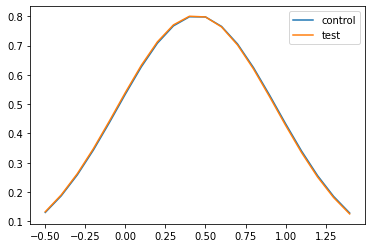

In [32]:
retention_rate=ab_test.groupby('version')['retention_1']

std=lambda x: np.std(x, ddof=0)                # std
error_std= lambda x: sem(x, ddof=0)            # error estandar (std / sqrt(n))

retention_rate=retention_rate.agg([np.mean, std, error_std])
retention_rate.columns=['conversion_rate', 'std_deviation', 'std_error']


retention_rate.style.format('{:.3f}')

x=[i*.1 for i in range(-5, 15)]  

control=[norm.pdf(x, retention_rate.iloc[0][0], retention_rate.iloc[0][1]) for x in x] 

test=[norm.pdf(x, retention_rate.iloc[1][0], retention_rate.iloc[1][1]) for x in x] 

plt.plot(x, control)
plt.plot(x, test)
plt.legend(['control', 'test']);

In [24]:
# test for retention_7
ctrl_ret7 = ab_test[ab_test.version == 'A']['retention_7']
test_ret7 = ab_test[ab_test.version == 'B']['retention_7']


In [25]:
count_ctrl_7 = ctrl_ret7.count()
count_test_7 = test_ret7.count()

retention_7 = [ctrl_ret7.sum(), test_ret7.sum()]

observations_7 = [count_ctrl_7, count_test_7]

z_score_7, p_value_7 = proportions_ztest(retention_7, observations_7)

# confidence intervals

(ctrl_ret7_a, test_ret7_a),(ctrl_ret7_b, test_ret7_b) = proportion_confint(retention_7, nobs=observations_7, alpha=0.05)

In [26]:
print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_value:.3f}')
print(f'Confidence Interval of 95% for control group: [{ctrl_ret7_a:.3f}, {ctrl_ret7_b:.3f}]')
print(f'Confidence Interval of 95% for test group: [{test_ret7_a:.3f}, {test_ret7_b:.3f}]')

z-score: 1.69
p-valor: 0.091
Confidence Interval of 95% for control group: [0.187, 0.194]
Confidence Interval of 95% for test group: [0.179, 0.186]


In [29]:
ab_test.groupby('version').retention_7.mean(), ab_test.groupby('version').retention_7.std()

(version
 A    0.190201
 B    0.182438
 Name: retention_7, dtype: float64,
 version
 A    0.392464
 B    0.386210
 Name: retention_7, dtype: float64)

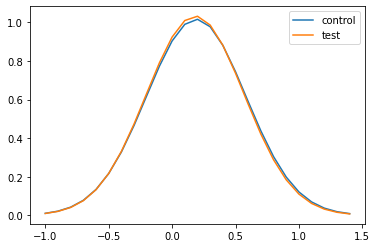

In [33]:
retention_rate_7=ab_test.groupby('version')['retention_7']

std=lambda x: np.std(x, ddof=0)                # std
error_std= lambda x: sem(x, ddof=0)            # error estandar (std / sqrt(n))

retention_rate_7 = retention_rate_7.agg([np.mean, std, error_std])
retention_rate_7.columns = ['conversion_rate', 'std_deviation', 'std_error']


retention_rate_7.style.format('{:.3f}')

x=[i*.1 for i in range(-10, 15)]  

control_7=[norm.pdf(x, retention_rate_7.iloc[0][0], retention_rate_7.iloc[0][1]) for x in x] 

test_7=[norm.pdf(x, retention_rate_7.iloc[1][0], retention_rate_7.iloc[1][1]) for x in x] 

plt.plot(x, control_7)
plt.plot(x, test_7)
plt.legend(['control', 'test']);

## Conclusions



    With this results we can say some thinks:
        
     - For retention 1 day we don´t find significantly differences, the retention rate are similar in both cases but little lower for gate 40
     - For retention 7 days with a 95% of confidence interval we can drop the H0 hipothesis and says that the gate 40 option is working a little better than the gate 30 option.